In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.11.0 True


**Install Detectron**

In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-d50cukb_
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-d50cukb_
  Resolved https://github.com/facebookresearch/detectron2.git to commit 42c44b622eb7b179576bdac218c84c107fff8eab
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 KB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.4/147.4 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

**Importing Libraries**

In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pandas as pd 

from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from tqdm.notebook import tqdm
tqdm.pandas()

from datetime import datetime
import time
import matplotlib.pyplot as plt

import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional
import json
import matplotlib.pyplot as plt

import ast


from tqdm import tqdm
import itertools

import torch
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from glob import glob
import numba
from numba import jit

from pycocotools.coco import COCO
# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset



from detectron2.evaluation.evaluator import DatasetEvaluator
import pycocotools.mask as mask_util
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

setup_logger()

<_Logger detectron2 (DEBUG)>

**Load the Data**

In [4]:
df_train = pd.read_csv('../input/person_and_car_detection/data/train.csv')

In [6]:
df_train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,image_000000001.jpg,1024,768,person,846,145,992,622
1,image_000000001.jpg,1024,768,person,848,216,1023,767
2,image_000000001.jpg,1024,768,car,74,159,149,240
3,image_000000001.jpg,1024,768,car,153,124,811,767
4,image_000000002.jpg,1024,576,person,488,281,516,352


In [7]:
df_train.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
13349,image_000002238.jpg,1024,683,car,734,0,849,53
13350,image_000002238.jpg,1024,683,car,869,8,931,50
13351,image_000002239.jpg,1024,685,person,192,137,222,184
13352,image_000002239.jpg,1024,685,person,474,171,606,415
13353,image_000002239.jpg,1024,685,car,48,173,571,672


In [8]:
df_train.shape

(13354, 8)

**Creating a COCO dataset**

In [9]:
x_min = df_train['xmin']
y_min = df_train['ymin']
x_max = df_train['xmax']
y_max = df_train['ymax']
bboxes = list()
for i in range(len(x_min)):
    bboxes.append([[x_min[i],y_min[i],x_max[i],y_max[i]]])
df_train['bboxes'] = bboxes

In [10]:
df_train["Width"]=df_train['width']
df_train["Height"]=df_train['height']
df_train.sample(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,bboxes,Width,Height
4860,image_000000752.jpg,1024,768,car,366,185,384,204,"[[366, 185, 384, 204]]",1024,768
10385,image_000001690.jpg,1024,685,car,0,292,83,339,"[[0, 292, 83, 339]]",1024,685


In [11]:
train_path = '../input/person_and_car_detection/data/trainval/images/'
path = list()
for i in df_train['filename']:
    path.append(train_path + i )

In [12]:
df_train['image_path'] = path
df_train.sample(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,bboxes,Width,Height,image_path
12140,image_000002026.jpg,1024,768,person,293,328,613,578,"[[293, 328, 613, 578]]",1024,768,../input/pedestrian-and-car-dataset/data/train...
11927,image_000001976.jpg,1024,768,car,764,471,801,507,"[[764, 471, 801, 507]]",1024,768,../input/pedestrian-and-car-dataset/data/train...


**Image Id**

In [13]:
id = list()
for i in df_train['filename']:
    id.append(i[:-4])

In [14]:
df_train['image_id'] = id
df_train.sample(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,bboxes,Width,Height,image_path,image_id
412,image_000000059.jpg,1024,675,person,361,113,375,146,"[[361, 113, 375, 146]]",1024,675,../input/pedestrian-and-car-dataset/data/train...,image_000000059
5781,image_000000910.jpg,1024,576,person,811,3,881,83,"[[811, 3, 881, 83]]",1024,576,../input/pedestrian-and-car-dataset/data/train...,image_000000910


In [15]:
# 0 for person, 1 for car
class_id = list()
for i in df_train['class']:
    if i == 'person':
        class_id.append(0)
    else:
        class_id.append(1)

In [16]:
df_train['class_id'] = class_id
df_train.sample(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,bboxes,Width,Height,image_path,image_id,class_id
650,image_000000113.jpg,1024,683,car,456,127,588,208,"[[456, 127, 588, 208]]",1024,683,../input/pedestrian-and-car-dataset/data/train...,image_000000113,1
1651,image_000000269.jpg,1024,683,person,451,186,545,255,"[[451, 186, 545, 255]]",1024,683,../input/pedestrian-and-car-dataset/data/train...,image_000000269,0


**Split the data**

In [17]:
n_spl=3
Selected_Fold=2 #0..2

from sklearn.model_selection import GroupKFold
gkf  = GroupKFold(n_splits = n_spl) # num_folds=3 as there are total 3 videos
df_train = df_train.reset_index(drop=True)
df_train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(df_train, groups = df_train.image_id.tolist())):
    df_train.loc[val_idx, 'fold'] = fold
display(df_train.fold.value_counts())

0    4452
2    4451
1    4451
Name: fold, dtype: int64

**COCO dataset for model**

In [18]:
def get_data_dicts(
    _train_df: pd.DataFrame,
    debug: bool = False,
    data_type:str="train"
   
):

    if debug:
        _train_df = _train_df.iloc[:10]  # For debug...
    dataset_dicts = []
    if data_type=="train":
        _train_df=_train_df[_train_df.fold != Selected_Fold]
    else: # val
        _train_df=_train_df[_train_df.fold == Selected_Fold] 
        
    for index, row in tqdm(_train_df.iterrows(), total=len(_train_df)):
        record = {}
        filename  = row.image_path #filename = str(f'{imgdir}/{image_id}.png')
        image_id = row.image_id
        image_height= row.Height
        image_width = row.Width
        bboxes_coco = row.bboxes
        class_id = row.class_id
        #bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
        record["file_name"] = filename
        record["image_id"] = image_id
        record["width"] = image_width
        record["height"] = image_height
        objs = []
        record["class_id"] = class_id
        for bbox_idx in range(len(bboxes_coco)):
            bbox=bboxes_coco[bbox_idx]
            obj = {
                    "bbox": bbox,
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": class_id,
                }
            objs.append(obj)
            record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [19]:
thing_classes=['person', 'car']
debug=False

Data_Resister_training="BR_data_train2";
Data_Resister_valid="BR_data_valid2";


DatasetCatalog.register(
    Data_Resister_training,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="train"
    ),
)
MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

DatasetCatalog.register(
    Data_Resister_valid,
    lambda: get_data_dicts(
        df_train,
        debug=debug,
        data_type="val"
        ),
    )
MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    

dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)

100%|██████████| 4451/4451 [00:00<00:00, 10262.10it/s]


**Visulaise the Bounding Boxes**

In [20]:
img = cv2.imread("../input/person_and_car_detection/data/trainval/images/image_000002220.jpg")

In [21]:
img

array([[[173, 173, 173],
        [172, 172, 172],
        [173, 173, 173],
        ...,
        [ 56,  56,  56],
        [ 55,  55,  55],
        [ 52,  52,  52]],

       [[176, 176, 176],
        [176, 176, 176],
        [176, 176, 176],
        ...,
        [ 52,  52,  52],
        [ 50,  50,  50],
        [ 50,  50,  50]],

       [[176, 176, 176],
        [176, 176, 176],
        [177, 177, 177],
        ...,
        [ 43,  43,  43],
        [ 44,  44,  44],
        [ 42,  42,  42]],

       ...,

       [[ 54,  54,  54],
        [ 65,  65,  65],
        [ 58,  58,  58],
        ...,
        [ 87,  87,  87],
        [ 82,  82,  82],
        [ 86,  86,  86]],

       [[ 33,  33,  33],
        [ 32,  32,  32],
        [ 51,  51,  51],
        ...,
        [ 91,  91,  91],
        [ 85,  85,  85],
        [ 88,  88,  88]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  5,   5,   5],
        ...,
        [ 91,  91,  91],
        [ 83,  83,  83],
        [ 85,  85,  85]]

file_name ../input/pedestrian-and-car-dataset/data/trainval/images/image_000000948.jpg
file_name ../input/pedestrian-and-car-dataset/data/trainval/images/image_000000648.jpg


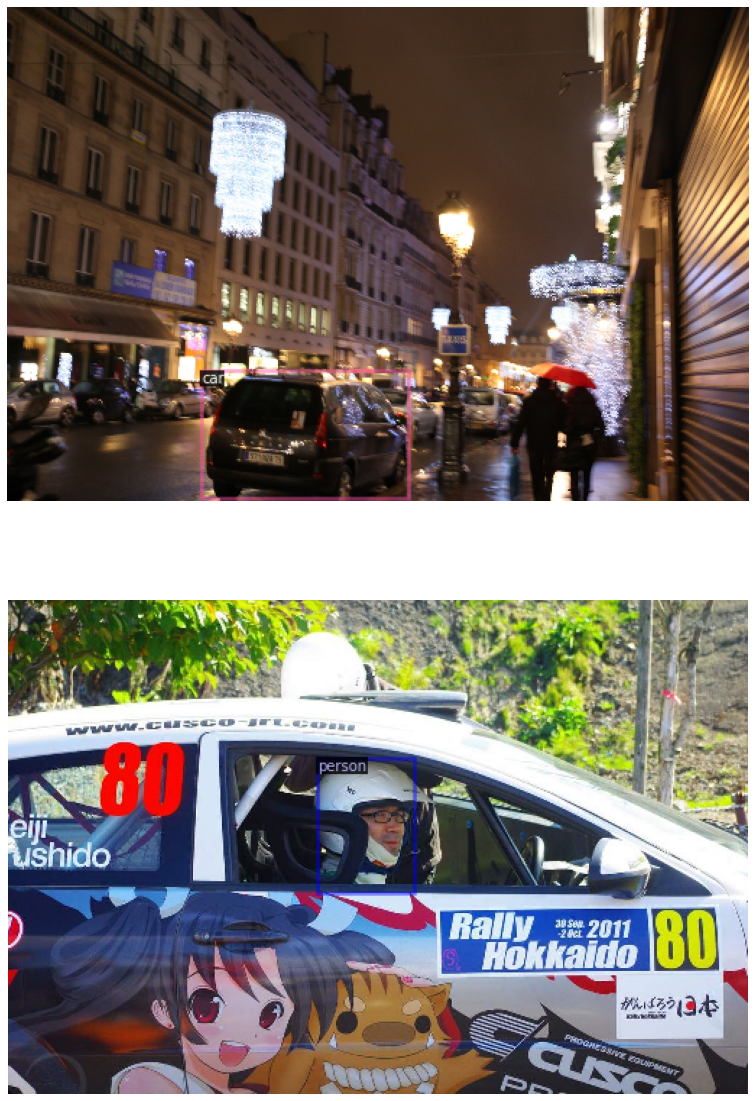

In [22]:
fig, ax = plt.subplots(2, 1, figsize =(35,20))
i=-1
for d in random.sample(dataset_dicts_train, 2):
    i=i+1    
    img = cv2.imread(d["file_name"])
    print("file_name", d["file_name"])
    v = Visualizer(img[:, :, :],
                   metadata=metadata_dicts_train, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    ax[i].grid(False)
    ax[i].axis('off')
    ax[i].imshow(out.get_image()[:, :, ::-1])

**LossEvalHook**

In [23]:
import logging
import numpy as np
from detectron2.engine.hooks import HookBase
from detectron2.evaluation import inference_context
from detectron2.utils.logger import log_every_n_seconds
from detectron2.data import DatasetMapper, build_detection_test_loader
import detectron2.utils.comm as comm
import torch
import time
import datetime

class LossEvalHook(HookBase):
    def __init__(self, cfg, model, data_loader):
        self._model = model
        self._period = cfg.TEST.EVAL_PERIOD
        self._root = cfg.OUTPUT_DIR
        self._data_loader = data_loader
        self._min_mean_loss = 0.0
        self._bfirst = True
    
    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)
            
        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):            
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (time.perf_counter() - start_time) / iters_after_start
                eta = datetime.timedelta(seconds=int(total_seconds_per_img * (total - idx - 1)))
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar('validation_loss', mean_loss)
        comm.synchronize()
        return mean_loss
            
    def _get_loss(self, data):
        # How loss is calculated on train_loop 
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced
                
    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            mean_loss = self._do_loss_eval()
            if self._bfirst:
                self._min_mean_loss = mean_loss
                self._bfirst = False
            #-------- save best model according to metrics --------
            if mean_loss < self._min_mean_loss:
                self._min_mean_loss = mean_loss
                self.trainer.checkpointer.save('model_best')
                with open('bestiter.txt', 'a+') as f:
                    f.write('min val loss: ' + str(mean_loss) + ' at iter: ' + str(self.trainer.iter) + '\n')


In [24]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name,("bbox",), True, output_folder)
        #return COCOEvaluator(dataset_name, cfg, True, output_folder)
    
        #return MAPIOUEvaluator(dataset_name)
    
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        return hooks

**Train the model**

In [25]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"  

cfg.merge_from_file(model_zoo.get_config_file(config_name))
cfg.DATASETS.TRAIN = (Data_Resister_training,)
cfg.DATASETS.TEST = (Data_Resister_valid,)

cfg.MODEL.WEIGHTS ="../input/brdetectron2l/output/model_best.pth" 

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # 64 is slower but more accurate (128 faster but less accurate)


cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class  + 1
cfg.MODEL.RETINANET.NUM_CLASSES = 3 # only has one class  + 1

cfg.SOLVER.IMS_PER_BATCH = 2 #(2 is per defaults)
cfg.SOLVER.BASE_LR = 0.0005 #(quite high base learning rate but should drop)
cfg.SOLVER.GAMMA = 0.1

    
cfg.SOLVER.WARMUP_ITERS = 10 #How many iterations to go from 0 to reach base LR
cfg.SOLVER.MAX_ITER = 800 #Maximum of iterations 1
cfg.SOLVER.STEPS = (200,400,750) #At which point to change the LR 0.25,0.5

cfg.TEST.EVAL_PERIOD = 60
#cfg.SOLVER.CHECKPOINT_PERIOD=100

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
#trainer = AugTrainer(cfg) # with  data augmentation  
trainer = Trainer(cfg)  # without data augmentation
trainer.resume_or_load(resume=False)
trainer.train()

[05/17 02:44:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

100%|██████████| 8903/8903 [00:01<00:00, 7271.54it/s] 

[05/17 02:44:41 d2.data.build]: Removed 0 images with no usable annotations. 8903 images left.


[05/17 02:44:42 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   person   | 5740         |    car     | 3163         |
|            |              |            |              |
|   total    | 8903         |            |              |
[05/17 02:44:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/17 02:44:42 d2.data.build]: Using training sampler TrainingSampler
[05/17 02:44:42 d2.data.common]: Serializing 8903 elements to byte tensors and concatenating them all ...
[05/17 02:44:42 d2.data.common]: Serialized dataset takes 3.74 MiB
[05/17 02:44:46 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333

100%|██████████| 4451/4451 [00:00<00:00, 10403.79it/s]


[05/17 02:44:46 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   person   | 2887         |    car     | 1564         |
|            |              |            |              |
|   total    | 4451         |            |              |
[05/17 02:44:47 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 02:44:47 d2.data.common]: Serialized dataset takes 1.87 MiB


model_final_280758.pkl: 167MB [00:04, 36.2MB/s]                              


[05/17 02:44:53 d2.engine.train_loop]: Starting training from iteration 0
[05/17 02:45:06 d2.utils.events]:  eta: 0:03:20  iter: 19  total_loss: 1.251  loss_cls: 0.7427  loss_box_reg: 0.236  loss_rpn_cls: 0.07651  loss_rpn_loc: 0.00816  time: 0.2642  data_time: 0.0180  lr: 0.0005  max_mem: 2514M
[05/17 02:45:11 d2.utils.events]:  eta: 0:03:17  iter: 39  total_loss: 0.7119  loss_cls: 0.3578  loss_box_reg: 0.2997  loss_rpn_cls: 0.0403  loss_rpn_loc: 0.005062  time: 0.2653  data_time: 0.0067  lr: 0.0005  max_mem: 2732M


100%|██████████| 4451/4451 [00:00<00:00, 5792.34it/s]


[05/17 02:45:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 02:45:18 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 02:45:18 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 02:45:18 d2.evaluation.coco_evaluation]: Trying to convert 'BR_data_valid2' to COCO format ...
[05/17 02:45:18 d2.data.datasets.coco]: Converting annotations of dataset 'BR_data_valid2' to COCO format ...)


100%|██████████| 4451/4451 [00:00<00:00, 10414.10it/s]

[05/17 02:45:18 d2.data.datasets.coco]: Converting dataset dicts into COCO format


[05/17 02:45:19 d2.data.datasets.coco]: Conversion finished, #images: 4451, #annotations: 4451
[05/17 02:45:19 d2.data.datasets.coco]: Caching COCO format annotations at './output/inference/BR_data_valid2_coco_format.json' ...
[05/17 02:45:19 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 02:45:20 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0051 s/iter. Inference: 0.0645 s/iter. Eval: 0.0005 s/iter. Total: 0.0702 s/iter. ETA=0:05:11
[05/17 02:45:25 d2.evaluation.evaluator]: Inference done 81/4451. Dataloading: 0.0039 s/iter. Inference: 0.0675 s/iter. Eval: 0.0006 s/iter. Total: 0.0722 s/iter. ETA=0:05:15
[05/17 02:45:30 d2.evaluation.evaluator]: Inference done 145/4451. Dataloading: 0.0050 s/iter. Inference: 0.0694 s/iter. Eval: 0.0005 s/iter. Total: 0.0751 s/iter. ETA=0:05:23
[05/17 02:45:35 d2.evaluation.evaluator]: Inference done 214/4451. Dataloading: 0.0047 s/iter. Inference: 0.0688 s/iter. Eval: 0.0005 s/iter. Total: 0.0742 s/iter. ETA=0:05:

100%|██████████| 4451/4451 [00:00<00:00, 9561.55it/s]


[05/17 02:57:03 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 02:57:03 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 02:57:03 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 02:57:03 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 02:57:04 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0054 s/iter. Inference: 0.0654 s/iter. Eval: 0.0005 s/iter. Total: 0.0714 s/iter. ETA=0:05:17
[05/17 02:57:10 d2.evaluation.evaluator]: Inference done 80/4451. Dataloading: 0.0043 s/iter. Inference: 0.0679 s/iter. Eval: 0.0005 s/iter. Total: 0.0729 s/iter. ETA=0:05:18
[05/17 02:57:15 d2.evaluation.evaluator]: Inference done 146/4451. Dataloading: 0.0049 s/iter. Inference: 0.0690 s/iter. Eval: 0.0005 s/iter. Total: 0.0746 s/iter. ETA=0:05:21
[05/17 02:57:20 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 10252.07it/s]


[05/17 03:08:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 03:08:48 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 03:08:48 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 03:08:48 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 03:08:49 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0057 s/iter. Inference: 0.0696 s/iter. Eval: 0.0005 s/iter. Total: 0.0758 s/iter. ETA=0:05:36
[05/17 03:08:54 d2.evaluation.evaluator]: Inference done 70/4451. Dataloading: 0.0077 s/iter. Inference: 0.0763 s/iter. Eval: 0.0005 s/iter. Total: 0.0847 s/iter. ETA=0:06:10
[05/17 03:08:59 d2.evaluation.evaluator]: Inference done 136/4451. Dataloading: 0.0074 s/iter. Inference: 0.0722 s/iter. Eval: 0.0005 s/iter. Total: 0.0802 s/iter. ETA=0:05:46
[05/17 03:09:04 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 9956.50it/s] 


[05/17 03:20:21 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 03:20:21 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 03:20:21 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 03:20:21 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 03:20:22 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0050 s/iter. Inference: 0.0619 s/iter. Eval: 0.0004 s/iter. Total: 0.0674 s/iter. ETA=0:04:59
[05/17 03:20:27 d2.evaluation.evaluator]: Inference done 69/4451. Dataloading: 0.0069 s/iter. Inference: 0.0773 s/iter. Eval: 0.0005 s/iter. Total: 0.0847 s/iter. ETA=0:06:11
[05/17 03:20:32 d2.evaluation.evaluator]: Inference done 135/4451. Dataloading: 0.0064 s/iter. Inference: 0.0736 s/iter. Eval: 0.0005 s/iter. Total: 0.0807 s/iter. ETA=0:05:48
[05/17 03:20:37 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 10282.35it/s]


[05/17 03:31:30 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 03:31:30 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 03:31:30 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 03:31:30 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 03:31:31 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0028 s/iter. Inference: 0.0607 s/iter. Eval: 0.0004 s/iter. Total: 0.0639 s/iter. ETA=0:04:43
[05/17 03:31:36 d2.evaluation.evaluator]: Inference done 86/4451. Dataloading: 0.0039 s/iter. Inference: 0.0626 s/iter. Eval: 0.0004 s/iter. Total: 0.0670 s/iter. ETA=0:04:52
[05/17 03:31:41 d2.evaluation.evaluator]: Inference done 150/4451. Dataloading: 0.0043 s/iter. Inference: 0.0674 s/iter. Eval: 0.0005 s/iter. Total: 0.0722 s/iter. ETA=0:05:10
[05/17 03:31:46 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 10797.41it/s]


[05/17 03:42:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 03:42:32 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 03:42:32 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 03:42:32 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 03:42:33 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0020 s/iter. Inference: 0.0630 s/iter. Eval: 0.0004 s/iter. Total: 0.0654 s/iter. ETA=0:04:50
[05/17 03:42:38 d2.evaluation.evaluator]: Inference done 82/4451. Dataloading: 0.0042 s/iter. Inference: 0.0655 s/iter. Eval: 0.0004 s/iter. Total: 0.0702 s/iter. ETA=0:05:06
[05/17 03:42:43 d2.evaluation.evaluator]: Inference done 146/4451. Dataloading: 0.0045 s/iter. Inference: 0.0690 s/iter. Eval: 0.0004 s/iter. Total: 0.0741 s/iter. ETA=0:05:19
[05/17 03:42:48 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 9221.36it/s]


[05/17 03:53:39 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 03:53:39 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 03:53:40 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 03:53:40 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 03:53:41 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0029 s/iter. Inference: 0.0589 s/iter. Eval: 0.0004 s/iter. Total: 0.0622 s/iter. ETA=0:04:36
[05/17 03:53:46 d2.evaluation.evaluator]: Inference done 86/4451. Dataloading: 0.0036 s/iter. Inference: 0.0625 s/iter. Eval: 0.0004 s/iter. Total: 0.0666 s/iter. ETA=0:04:50
[05/17 03:53:51 d2.evaluation.evaluator]: Inference done 152/4451. Dataloading: 0.0042 s/iter. Inference: 0.0662 s/iter. Eval: 0.0004 s/iter. Total: 0.0709 s/iter. ETA=0:05:04
[05/17 03:53:56 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 9607.32it/s]


[05/17 04:04:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 04:04:51 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 04:04:51 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 04:04:51 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 04:04:53 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0061 s/iter. Inference: 0.0667 s/iter. Eval: 0.0005 s/iter. Total: 0.0733 s/iter. ETA=0:05:25
[05/17 04:04:58 d2.evaluation.evaluator]: Inference done 84/4451. Dataloading: 0.0045 s/iter. Inference: 0.0646 s/iter. Eval: 0.0004 s/iter. Total: 0.0696 s/iter. ETA=0:05:03
[05/17 04:05:03 d2.evaluation.evaluator]: Inference done 145/4451. Dataloading: 0.0055 s/iter. Inference: 0.0692 s/iter. Eval: 0.0005 s/iter. Total: 0.0753 s/iter. ETA=0:05:24
[05/17 04:05:08 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 9875.21it/s] 


[05/17 04:16:09 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 04:16:09 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 04:16:10 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 04:16:10 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 04:16:11 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0052 s/iter. Inference: 0.0758 s/iter. Eval: 0.0004 s/iter. Total: 0.0814 s/iter. ETA=0:06:01
[05/17 04:16:16 d2.evaluation.evaluator]: Inference done 85/4451. Dataloading: 0.0037 s/iter. Inference: 0.0646 s/iter. Eval: 0.0004 s/iter. Total: 0.0689 s/iter. ETA=0:05:01
[05/17 04:16:21 d2.evaluation.evaluator]: Inference done 153/4451. Dataloading: 0.0038 s/iter. Inference: 0.0668 s/iter. Eval: 0.0005 s/iter. Total: 0.0713 s/iter. ETA=0:05:06
[05/17 04:16:26 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 10482.83it/s]


[05/17 04:27:25 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 04:27:25 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 04:27:25 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 04:27:25 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 04:27:26 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0054 s/iter. Inference: 0.0631 s/iter. Eval: 0.0004 s/iter. Total: 0.0689 s/iter. ETA=0:05:05
[05/17 04:27:31 d2.evaluation.evaluator]: Inference done 84/4451. Dataloading: 0.0038 s/iter. Inference: 0.0650 s/iter. Eval: 0.0004 s/iter. Total: 0.0694 s/iter. ETA=0:05:02
[05/17 04:27:36 d2.evaluation.evaluator]: Inference done 148/4451. Dataloading: 0.0047 s/iter. Inference: 0.0681 s/iter. Eval: 0.0004 s/iter. Total: 0.0734 s/iter. ETA=0:05:15
[05/17 04:27:41 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 10218.72it/s]


[05/17 04:38:41 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 04:38:41 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 04:38:41 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 04:38:41 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 04:38:42 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0053 s/iter. Inference: 0.0647 s/iter. Eval: 0.0004 s/iter. Total: 0.0704 s/iter. ETA=0:05:12
[05/17 04:38:47 d2.evaluation.evaluator]: Inference done 82/4451. Dataloading: 0.0047 s/iter. Inference: 0.0660 s/iter. Eval: 0.0004 s/iter. Total: 0.0712 s/iter. ETA=0:05:11
[05/17 04:38:52 d2.evaluation.evaluator]: Inference done 151/4451. Dataloading: 0.0041 s/iter. Inference: 0.0675 s/iter. Eval: 0.0005 s/iter. Total: 0.0721 s/iter. ETA=0:05:10
[05/17 04:38:57 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 10106.38it/s]


[05/17 04:49:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 04:49:56 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 04:49:56 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 04:49:56 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 04:49:57 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0036 s/iter. Inference: 0.0679 s/iter. Eval: 0.0004 s/iter. Total: 0.0719 s/iter. ETA=0:05:19
[05/17 04:50:03 d2.evaluation.evaluator]: Inference done 85/4451. Dataloading: 0.0047 s/iter. Inference: 0.0635 s/iter. Eval: 0.0005 s/iter. Total: 0.0688 s/iter. ETA=0:05:00
[05/17 04:50:08 d2.evaluation.evaluator]: Inference done 139/4451. Dataloading: 0.0059 s/iter. Inference: 0.0719 s/iter. Eval: 0.0006 s/iter. Total: 0.0785 s/iter. ETA=0:05:38
[05/17 04:50:13 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 10398.14it/s]


[05/17 05:01:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 05:01:13 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 05:01:13 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 05:01:13 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 05:01:14 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0021 s/iter. Inference: 0.0638 s/iter. Eval: 0.0004 s/iter. Total: 0.0663 s/iter. ETA=0:04:54
[05/17 05:01:19 d2.evaluation.evaluator]: Inference done 80/4451. Dataloading: 0.0053 s/iter. Inference: 0.0664 s/iter. Eval: 0.0004 s/iter. Total: 0.0722 s/iter. ETA=0:05:15
[05/17 05:01:24 d2.evaluation.evaluator]: Inference done 150/4451. Dataloading: 0.0047 s/iter. Inference: 0.0669 s/iter. Eval: 0.0005 s/iter. Total: 0.0723 s/iter. ETA=0:05:10
[05/17 05:01:29 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 9003.07it/s]


[05/17 05:17:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 05:17:42 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 05:17:42 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 05:17:42 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 05:17:43 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0070 s/iter. Inference: 0.0586 s/iter. Eval: 0.0004 s/iter. Total: 0.0660 s/iter. ETA=0:04:53
[05/17 05:17:48 d2.evaluation.evaluator]: Inference done 82/4451. Dataloading: 0.0047 s/iter. Inference: 0.0658 s/iter. Eval: 0.0004 s/iter. Total: 0.0710 s/iter. ETA=0:05:10
[05/17 05:17:53 d2.evaluation.evaluator]: Inference done 144/4451. Dataloading: 0.0056 s/iter. Inference: 0.0693 s/iter. Eval: 0.0004 s/iter. Total: 0.0755 s/iter. ETA=0:05:25
[05/17 05:17:58 d2.evaluation.evaluator]: Infere

**Evaluate the model**

In [26]:
print('test model final:')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(Data_Resister_valid,  False, output_dir="./output_final/")
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
print(inference_on_dataset(trainer.model, val_loader, evaluator))


print('test model best:')
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_best.pth") 
#cfg.MODEL.WEIGHTS="./output/model_best.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator(Data_Resister_valid, False, output_dir="./output_best/") #bbox
val_loader = build_detection_test_loader(cfg, Data_Resister_valid)
print(inference_on_dataset(trainer.model, val_loader, evaluator))

test model final:
[05/17 05:30:32 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2

100%|██████████| 4451/4451 [00:00<00:00, 10754.37it/s]


[05/17 05:30:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 05:30:33 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 05:30:33 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 05:30:33 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 05:30:34 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0034 s/iter. Inference: 0.0639 s/iter. Eval: 0.0004 s/iter. Total: 0.0677 s/iter. ETA=0:05:00
[05/17 05:30:39 d2.evaluation.evaluator]: Inference done 81/4451. Dataloading: 0.0048 s/iter. Inference: 0.0662 s/iter. Eval: 0.0005 s/iter. Total: 0.0716 s/iter. ETA=0:05:12
[05/17 05:30:44 d2.evaluation.evaluator]: Inference done 143/4451. Dataloading: 0.0052 s/iter. Inference: 0.0700 s/iter. Eval: 0.0005 s/iter. Total: 0.0758 s/iter. ETA=0:05:26
[05/17 05:30:49 d2.evaluation.evaluator]: Infere

100%|██████████| 4451/4451 [00:00<00:00, 5031.17it/s] 


[05/17 05:36:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/17 05:36:07 d2.data.common]: Serializing 4451 elements to byte tensors and concatenating them all ...
[05/17 05:36:07 d2.data.common]: Serialized dataset takes 1.87 MiB
[05/17 05:36:07 d2.evaluation.evaluator]: Start inference on 4451 batches
[05/17 05:36:08 d2.evaluation.evaluator]: Inference done 11/4451. Dataloading: 0.0052 s/iter. Inference: 0.0653 s/iter. Eval: 0.0005 s/iter. Total: 0.0709 s/iter. ETA=0:05:14
[05/17 05:36:13 d2.evaluation.evaluator]: Inference done 77/4451. Dataloading: 0.0048 s/iter. Inference: 0.0708 s/iter. Eval: 0.0006 s/iter. Total: 0.0763 s/iter. ETA=0:05:33
[05/17 05:36:18 d2.evaluation.evaluator]: Inference done 142/4451. Dataloading: 0.0058 s/iter. Inference: 0.0702 s/iter. Eval: 0.0005 s/iter. Total: 0.0766 s/iter. ETA=0:05:30
[05/17 05:36:23 d2.evaluation.evaluator]: Infere

**Plot the performance of the model**

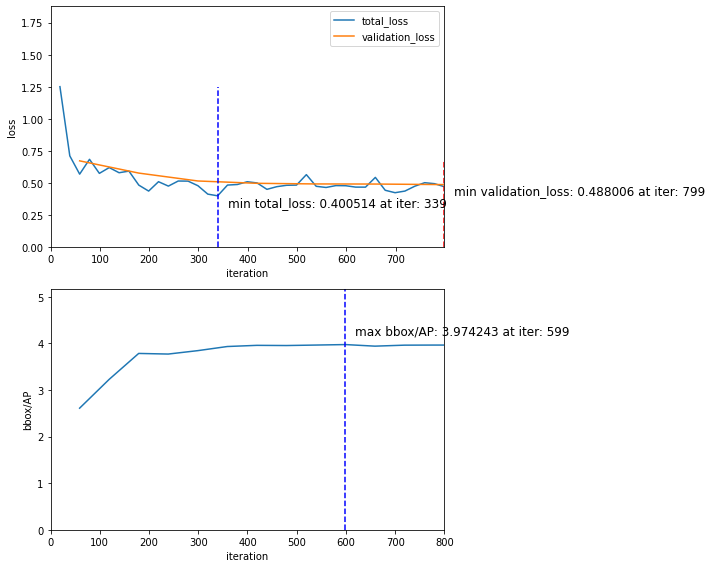

In [27]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines
experiment_metrics = load_json_arr('./output/metrics.json')

iters_total_loss = [x['iteration'] for x in experiment_metrics if 'total_loss' in x]
total_loss = [x['total_loss'] for x in experiment_metrics if 'total_loss' in x]


iters_validation_loss = [x['iteration'] for x in experiment_metrics if 'validation_loss' in x]
validation_loss = [x['validation_loss'] for x in experiment_metrics if 'validation_loss' in x]

iters_AP = [x['iteration'] for x in experiment_metrics if 'bbox/AP' in x]
AP = [x['bbox/AP'] for x in experiment_metrics if 'bbox/AP' in x]

fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].plot(iters_total_loss, total_loss)
ax[0].plot(iters_validation_loss, validation_loss)
ax[0].set_xlabel('iteration')
ax[0].set_ylabel('loss')
ax[0].legend(['total_loss', 'validation_loss'], loc='best')

iter = validation_loss.index(min(validation_loss))
ax[0].vlines(iters_validation_loss[iter], 0, float(max(validation_loss)),color="red",linestyles ="dashed")
ax[0].annotate('min validation_loss: %f at iter: %d'%(float(min(validation_loss)),int(iters_validation_loss[iter])),xy=(iters_validation_loss[iter],min(validation_loss)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

iter = total_loss.index(min(total_loss))
ax[0].vlines(iters_total_loss[iter], 0, float(max(total_loss)),color="blue",linestyles ="dashed")
ax[0].annotate('min total_loss: %f at iter: %d'%(float(min(total_loss)),int(iters_total_loss[iter])),xy=(iters_total_loss[iter],min(total_loss)),xytext=(+10,-10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')

ax[0].set_xlim([0,max(max(iters_total_loss),max(iters_validation_loss))])
ax[0].set_ylim([0,max(1.5*max(total_loss),1.5*max(validation_loss))])
#ax[0].legend(bbox_to_anchor=(1.0, 1.0))

ax[1].plot(iters_AP, AP)
ax[1].set_xlabel('iteration')
ax[1].set_ylabel('bbox/AP')
iter = AP.index(max(AP))
ax[1].vlines(iters_AP[iter], 0, 5+float(max(AP)),color="blue",linestyles ="dashed")
ax[1].annotate('max bbox/AP: %f at iter: %d'%(float(max(AP)),int(iters_AP[iter])),xy=(iters_AP[iter],max(AP)),xytext=(+10,+10),textcoords='offset points',fontsize=12) #arrowprops=dict(arrowstyle='->',connectionstyle='arc3,rad=.2')
ax[1].set_xlim([0,max(iters_AP)])
ax[1].set_ylim([0,max(AP)*1.3])

fig.tight_layout()  
plt.show()